In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("mbsoroush/rice-images-dataset")

print("Path to dataset files:", dataset_path)

100%|██████████| 220M/220M [00:05<00:00, 40.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mbsoroush/rice-images-dataset/versions/1


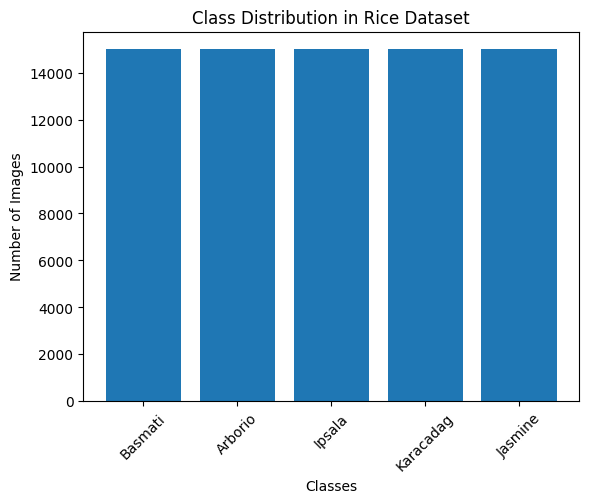

In [ ]:
import os
import matplotlib.pyplot as plt

# List of classes (subfolders)
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

# Count images in each class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Plot the distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Rice Dataset")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [ ]:
import os
import shutil
import random

# Set the path to your dataset (original dataset)
dataset_path = kagglehub.dataset_download("mbsoroush/rice-images-dataset")  # Update this with your actual dataset path

# Set the path for the split data
output_dir = "./split_data"  # Directory where you want to store the split data

# Define train, validation, and test directory paths
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create the directories if they don't exist
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)


In [ ]:
# Create subdirectories for each class inside train, val, and test directories
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)


In [ ]:
# Split the dataset
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

    # Shuffle images randomly to split them
    random.shuffle(images)

    # 80% for training, 20% for testing
    num_train = int(0.8 * len(images))
    num_val = int(0.2 * num_train)

    # Split into train, validation, and test sets
    train_images = images[:num_train - num_val]
    val_images = images[num_train - num_val:num_train]
    test_images = images[num_train:]

    # Move the images to their respective directories
    for image in train_images:
        shutil.move(os.path.join(class_path, image), os.path.join(train_dir, cls, image))

    for image in val_images:
        shutil.move(os.path.join(class_path, image), os.path.join(val_dir, cls, image))

    for image in test_images:
        shutil.move(os.path.join(class_path, image), os.path.join(test_dir, cls, image))


In [ ]:
# Initialize ImageDataGenerators for training, validation, and test
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training data from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow validation data from the directory
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow test data from the directory
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Print dataset statistics
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

# Print class names and corresponding indices
print("\nClass names and indices:")
print(train_generator.class_indices)

Found 48000 images belonging to 5 classes.
Found 12000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Training samples: 48000
Validation samples: 12000
Testing samples: 15000

Class names and indices:
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization, Flatten, Conv2D, MaxPool2D

# Build the model
model = Sequential()
for layer in vgg16_base.layers:
  model.add(layer)
# Freeze the layers of VGG16 to retain the pre-trained weights
for layer in model.layers:
  layer.trainable = False # Not trainable weights

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,204,549 (80.89 MB)

 Trainable params: 6,489,861 (24.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Increased epochs to allow more training
    callbacks=[early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 739s 481ms/step - accuracy: 0.6726 - loss: 0.8225 - val_accuracy: 0.9640 - val_loss: 0.1108
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 666s 442ms/step - accuracy: 0.9062 - loss: 0.2629 - val_accuracy: 0.9724 - val_loss: 0.0787
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 682s 442ms/step - accuracy: 0.9269 - loss: 0.2096 - val_accuracy: 0.9700 - val_loss: 0.0835
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 682s 442ms/step - accuracy: 0.9309 - loss: 0.1919 - val_accuracy: 0.9828 - val_loss: 0.0549
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 699s 453ms/step - accuracy: 0.9393 - loss: 0.1765 - val_accuracy: 0.9668 - val_loss: 0.1008
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 683s 454ms/step - accuracy: 0.9442 - loss: 0.1622 - val_accuracy: 0.9773 - val_loss: 0.0682
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 684s 454ms/step - accuracy: 0.9470 - loss: 0.1543 - val_accuracy: 0.9858 - val_loss: 0.0447
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 749s 459ms/step - accuracy: 0.9

In [ ]:
# Evaluate Model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 66s 141ms/step - accuracy: 0.9880 - loss: 0.0362
Test Loss: 0.04118825122714043
Test Accuracy: 0.9864000082015991


In [ ]:
# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {val_accuracy*100:.2f}%, Test Loss: {val_loss:.2f}')

469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.9880 - loss: 0.0362
Test Accuracy: 98.64%, Test Loss: 0.04


469/469 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step


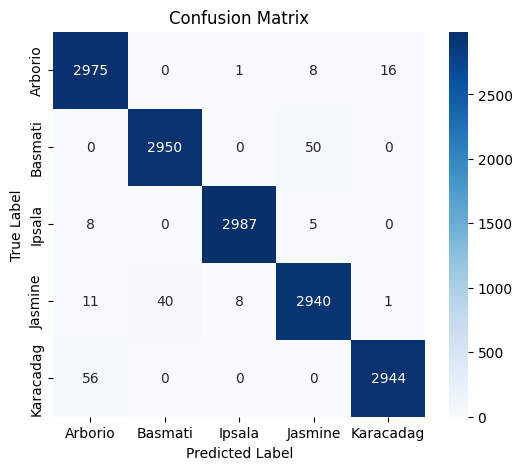

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Step 1: Make predictions on the test set
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# Convert predictions to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Step 2: Get true labels from the test generator
Y_true = test_generator.classes

# Step 3: Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Step 4: Plot the confusion matrix
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot the confusion matrix
class_labels = list(test_generator.class_indices.keys())  # Get class names
plot_confusion_matrix(confusion_mtx, classes=class_labels)


In [ ]:
# Classificatio report

from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(Y_true, Y_pred_classes, digits=4)
print(report)


              precision    recall  f1-score   support

           0     0.9754    0.9917    0.9835      3000
           1     0.9866    0.9833    0.9850      3000
           2     0.9970    0.9957    0.9963      3000
           3     0.9790    0.9800    0.9795      3000
           4     0.9943    0.9813    0.9878      3000

    accuracy                         0.9864     15000
   macro avg     0.9865    0.9864    0.9864     15000
weighted avg     0.9865    0.9864    0.9864     15000

